# 📊 Data Preparation and Split

Bu notebook, SEMI_TRUTHS dataset'ini eğitim için hazırlar ve train/val/test split yapar.

## 🎯 Hedefler:
1. Tüm CSV metadata dosyalarını yükle ve birleştir
2. Top 49 mask'ı filtrele (5 domain: URBAN, HUMAN_BODY, CLOTHING, INDOOR, BACKGROUND)
3. Real-Fake görsel eşleştirmesi yap
4. **Data leakage önlemek için real_id bazlı split** yap (%70 train, %15 val, %15 test)
5. 9 CSV dosyası oluştur:
   - fake_only_split: fake_train, fake_val, fake_test
   - real_only_split: real_train, real_val, real_test
   - paired_split: paired_train, paired_val, paired_test

## ⚠️ Önemli:
- **Real ID bazlı split**: Aynı real görsellerden üretilen fake'ler aynı split'te (data leakage YOK)
- **Tüm real'ler kullanılır**: Fake'i olmayan real'ler de real_only_split'e dahil
- **49 mask (5 domain)**: Hierarchical classification için hazır

## 1️⃣ Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
from pathlib import Path
from collections import defaultdict, Counter
from datetime import datetime
import json

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Seed sabitle (reproducibility)
random.seed(42)
np.random.seed(42)

print("✅ Kütüphaneler yüklendi")
print(f"📅 Tarih: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Kütüphaneler yüklendi
📅 Tarih: 2025-12-29 00:08:46


## 2️⃣ Veri Yolları & Ayarlar

In [2]:
# =============================================
# 🔧 AYARLAR
# =============================================

# Veri yolları
CSV_BASE = r"C:\AI_DATA\SEMI_TRUTHS\inpainting"
EXTRACTED_BASE_FAKE = r"C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting"
EXTRACTED_BASE_REAL = r"C:\AI_DATA\SEMI_TRUTHS_extracted\original\images"

# Output klasörü
OUTPUT_DIR = r"dataset_splits"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Split klasörleri
FAKE_ONLY_DIR = os.path.join(OUTPUT_DIR, "fake_only_split")
REAL_ONLY_DIR = os.path.join(OUTPUT_DIR, "real_only_split")
PAIRED_DIR = os.path.join(OUTPUT_DIR, "paired_split")

os.makedirs(FAKE_ONLY_DIR, exist_ok=True)
os.makedirs(REAL_ONLY_DIR, exist_ok=True)
os.makedirs(PAIRED_DIR, exist_ok=True)

# Split oranları
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

assert TRAIN_RATIO + VAL_RATIO + TEST_RATIO == 1.0, "Split oranları toplamı 1.0 olmalı!"

print("="*70)
print("📁 KLASÖR YAPISI")
print("="*70)
print(f"CSV Base: {CSV_BASE}")
print(f"Extracted Fake: {EXTRACTED_BASE_FAKE}")
print(f"Extracted Real: {EXTRACTED_BASE_REAL}")
print(f"\nOutput: {OUTPUT_DIR}")
print(f"  ├─ fake_only_split/")
print(f"  ├─ real_only_split/")
print(f"  └─ paired_split/")
print(f"\n📊 SPLIT ORANLARI")
print(f"  Train: {TRAIN_RATIO*100:.0f}%")
print(f"  Val:   {VAL_RATIO*100:.0f}%")
print(f"  Test:  {TEST_RATIO*100:.0f}%")
print("="*70)

📁 KLASÖR YAPISI
CSV Base: C:\AI_DATA\SEMI_TRUTHS\inpainting
Extracted Fake: C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting
Extracted Real: C:\AI_DATA\SEMI_TRUTHS_extracted\original\images

Output: dataset_splits
  ├─ fake_only_split/
  ├─ real_only_split/
  └─ paired_split/

📊 SPLIT ORANLARI
  Train: 70%
  Val:   15%
  Test:  15%


## 3️⃣ Domain Kategorileri (49 Mask)

In [3]:
# =============================================
# 🏷️ DOMAIN KATEGORİLERİ (5 Domain, 49 Mask)
# =============================================

DOMAIN_CATEGORIES = {
    'URBAN': [
        'building', 'car', 'road', 'sidewalk', 'vegetation', 'sky', 
        'wall', 'window', 'door', 'tree', 'trees', 'pole', 'fence', 
        'parking', 'terrain'
    ],
    'HUMAN_BODY': [
        'hair', 'face', 'skin', 'neck', 'nose', 'Right-arm', 'Left-arm',
        'Right-leg', 'Left-leg', 'left_ear', 'right_ear', 'mouth', 
        'upper_lip', 'lower_lip'
    ],
    'CLOTHING': [
        'Upper-clothes', 'Pants', 'skirt', 'dress', 'hat', 'bag', 'cloth'
    ],
    'INDOOR': [
        'floor', 'ceiling', 'chair', 'table', 'seat', 'column', 'ground', 'grass'
    ],
    'BACKGROUND': [
        'background', 'out of roi', 'ego vehicle', 'rectification border', 'static'
    ]
}

DOMAIN_NAMES = list(DOMAIN_CATEGORIES.keys())
NUM_DOMAINS = len(DOMAIN_NAMES)

# Mask → Domain mapping
mask_to_domain = {}
mask_to_domain_id = {}

for domain_id, (domain, masks) in enumerate(DOMAIN_CATEGORIES.items()):
    for mask in masks:
        mask_to_domain[mask] = domain
        mask_to_domain_id[mask] = domain_id

# Toplam mask sayısı
total_masks = sum(len(masks) for masks in DOMAIN_CATEGORIES.values())

print("="*70)
print(f"🏷️  DOMAIN KATEGORİLERİ")
print("="*70)
print(f"\n✅ {NUM_DOMAINS} Domain, {total_masks} Mask tanımlandı:\n")

for i, (domain, masks) in enumerate(DOMAIN_CATEGORIES.items()):
    print(f"   [{i}] {domain:<15} → {len(masks):2d} masks")
    print(f"       {', '.join(masks[:5])}...")

print(f"\n✅ mask_to_domain sözlüğü oluşturuldu")
print(f"   Örnek: 'building' → '{mask_to_domain['building']}' (domain_id: {mask_to_domain_id['building']})")
print(f"   Örnek: 'hair' → '{mask_to_domain['hair']}' (domain_id: {mask_to_domain_id['hair']})")
print("="*70)

🏷️  DOMAIN KATEGORİLERİ

✅ 5 Domain, 49 Mask tanımlandı:

   [0] URBAN           → 15 masks
       building, car, road, sidewalk, vegetation...
   [1] HUMAN_BODY      → 14 masks
       hair, face, skin, neck, nose...
   [2] CLOTHING        →  7 masks
       Upper-clothes, Pants, skirt, dress, hat...
   [3] INDOOR          →  8 masks
       floor, ceiling, chair, table, seat...
   [4] BACKGROUND      →  5 masks
       background, out of roi, ego vehicle, rectification border, static...

✅ mask_to_domain sözlüğü oluşturuldu
   Örnek: 'building' → 'URBAN' (domain_id: 0)
   Örnek: 'hair' → 'HUMAN_BODY' (domain_id: 1)


## 4️⃣ CSV Dosyalarını Yükle

In [4]:
# =============================================
# 📋 TÜM CSV DOSYALARINI YÜKLE VE BİRLEŞTİR
# =============================================

print("="*70)
print("📋 CSV DOSYALARI YÜKLENİYOR")
print("="*70)

# CSV dosyalarını bul
csv_files = glob.glob(os.path.join(CSV_BASE, "**", "*_meta.csv"), recursive=True)
print(f"\n🔍 Bulunan CSV dosyası: {len(csv_files)}\n")

if len(csv_files) == 0:
    raise FileNotFoundError(f"❌ {CSV_BASE} klasöründe CSV dosyası bulunamadı!")

# Tüm CSV'leri yükle ve birleştir
all_dfs = []

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        
        # Dataset bilgilerini ekle
        csv_dir = os.path.dirname(csv_file)
        parent_folder = os.path.basename(os.path.dirname(csv_dir))  # ADE20K, CelebAHQ
        model_name = os.path.basename(csv_dir)  # StableDiffusion_XL, Kandinsky_2_2
        
        df['parent_dataset'] = parent_folder
        df['model_name'] = model_name
        df['dataset'] = f"{parent_folder}_{model_name}"
        df['csv_source_path'] = csv_file
        
        all_dfs.append(df)
        
        relative_path = os.path.relpath(csv_file, CSV_BASE)
        print(f"   ✅ {relative_path}")
        print(f"      └─ {len(df):,} satır")
        
    except Exception as e:
        print(f"   ❌ Hata: {csv_file}")
        print(f"      {e}")

# Birleştir
df_combined = pd.concat(all_dfs, ignore_index=True)

print(f"\n{'='*70}")
print(f"✅ TOPLAM: {len(df_combined):,} görsel metadata birleştirildi")
print(f"{'='*70}")

# Sütun bilgisi
print(f"\n📊 CSV Sütunları ({len(df_combined.columns)} adet):")
print(f"   {', '.join(df_combined.columns[:10])}...")

📋 CSV DOSYALARI YÜKLENİYOR

🔍 Bulunan CSV dosyası: 6

   ✅ ADE20K\StableDiffusion_v5\ADE20K_StableDiffusion_v5_meta.csv
      └─ 48,196 satır
   ✅ ADE20K\StableDiffusion_XL\ADE20K_StableDiffusion_XL_meta.csv
      └─ 48,468 satır
   ✅ CelebAHQ\Kandinsky_2_2\CelebAHQ_Kandinsky_2_2_meta.csv
      └─ 14,730 satır
   ✅ CityScapes\Kandinsky_2_2\CityScapes_Kandinsky_2_2_meta.csv
      └─ 44,649 satır
   ✅ HumanParsing\OpenJourney\HumanParsing_OpenJourney_meta.csv
      └─ 29,061 satır
   ✅ OpenImages\StableDiffusion_XL\OpenImages_StableDiffusion_XL_meta.csv
      └─ 7,332 satır

✅ TOPLAM: 192,436 görsel metadata birleştirildi

📊 CSV Sütunları (30 adet):
   Unnamed: 0, img_id, mask_id, mask_name, area_ratio, perturbed_caption, sem_magnitude, pass_qc, dataset, diffusion_model...


## 5️⃣ Top 49 Mask Filtreleme ve Domain Etiketleme

In [5]:
# =============================================
# 🔍 TOP 49 MASK FİLTRELEME VE DOMAIN ETİKETLEME
# =============================================

print("="*70)
print("🔍 TOP 49 MASK FİLTRELEME")
print("="*70)

# Tüm mask listesi
all_masks_in_domains = set()
for masks in DOMAIN_CATEGORIES.values():
    all_masks_in_domains.update(masks)

print(f"\n📌 Domain'lerdeki toplam mask: {len(all_masks_in_domains)}")

# Filtreleme öncesi
print(f"\n📊 Filtreleme öncesi:")
print(f"   Toplam görsel: {len(df_combined):,}")
print(f"   Unique mask'lar: {df_combined['mask_name'].nunique()}")

# Top 49 mask'ları filtrele
df_filtered = df_combined[df_combined['mask_name'].isin(all_masks_in_domains)].copy()

print(f"\n📊 Filtreleme sonrası (Top 49 mask):")
print(f"   Kalan görsel: {len(df_filtered):,}")
print(f"   Filtrelenen: {len(df_combined) - len(df_filtered):,}")

# Domain etiketlerini ekle
df_filtered['domain'] = df_filtered['mask_name'].map(mask_to_domain)
df_filtered['domain_id'] = df_filtered['mask_name'].map(mask_to_domain_id)

print(f"\n✅ Domain etiketleri eklendi")

# Domain dağılımı
print(f"\n📊 Domain Dağılımı:")
domain_counts = df_filtered['domain'].value_counts()
for domain, count in domain_counts.items():
    pct = count / len(df_filtered) * 100
    print(f"   {domain:<15} : {count:>6,} ({pct:>5.1f}%)")

print("="*70)

🔍 TOP 49 MASK FİLTRELEME

📌 Domain'lerdeki toplam mask: 49

📊 Filtreleme öncesi:
   Toplam görsel: 192,436
   Unique mask'lar: 1557

📊 Filtreleme sonrası (Top 49 mask):
   Kalan görsel: 121,314
   Filtrelenen: 71,122

✅ Domain etiketleri eklendi

📊 Domain Dağılımı:
   URBAN           : 67,523 ( 55.7%)
   HUMAN_BODY      : 20,840 ( 17.2%)
   INDOOR          : 16,920 ( 13.9%)
   BACKGROUND      :  9,614 (  7.9%)
   CLOTHING        :  6,417 (  5.3%)


## 6️⃣ Real ID Çıkarma Fonksiyonu

In [6]:
# =============================================
# 🔑 REAL ID ÇIKARMA FONKSİYONU
# =============================================

def extract_real_id(fake_img_id: str) -> str:
    """
    Fake görsel ID'sinden real görsel ID'sini çıkarır.
    
    Örnekler:
    - "instance_000_ADE_frame_00000004_ADE20K_StableDiffusion_v5"
      → "ADE_frame_00000004"
    
    - "instance_011_dcd540c9_CelebAHQ_Kandinsky_2_2"
      → "dcd540c9"
    
    Args:
        fake_img_id: Fake görselin ID'si (perturbed_img_id)
    
    Returns:
        real_img_id: Real görselin ID'si
    """
    parts = fake_img_id.split("_")
    
    # "instance_XXX_" önekini at
    if parts[0] == "instance" and len(parts) > 2:
        core = parts[2:]  # instance_000_ kısmını at
    else:
        core = parts
    
    # Dataset adlarını tanımla
    known_datasets = {'ADE20K', 'CityScapes', 'CelebAHQ', 
                     'HumanParsing', 'OpenImages'}
    
    # Dataset adından önceki kısım real ID'dir
    for i, part in enumerate(core):
        if part in known_datasets:
            # Dataset'ten önceki tüm parçalar real ID
            return "_".join(core[:i])
    
    # Dataset bulunamadıysa, son iki parçayı at (model adı)
    if len(core) > 2:
        return "_".join(core[:-2])
    
    return "_".join(core)


# Test fonksiyonu
print("="*70)
print("🧪 REAL ID ÇIKARMA TESTİ")
print("="*70)

test_cases = [
    "instance_000_ADE_frame_00000004_ADE20K_StableDiffusion_v5",
    "instance_011_dcd540c9_CelebAHQ_Kandinsky_2_2",
    "instance_020_ADE_train_00001234_ADE20K_StableDiffusion_XL",
]

print("\nTest örnekleri:\n")
for fake_id in test_cases:
    real_id = extract_real_id(fake_id)
    print(f"Fake: {fake_id}")
    print(f"Real: {real_id}")
    print()

# CSV'deki gerçek örneklerle test
if len(df_filtered) > 0:
    print("\nCSV'den gerçek örnekler:\n")
    for i, row in df_filtered.sample(3).iterrows():
        fake_id = row['perturbed_img_id']
        real_id = extract_real_id(fake_id)
        print(f"Fake: {fake_id}")
        print(f"Real: {real_id}")
        print()

print("✅ Real ID çıkarma fonksiyonu hazır")
print("="*70)

🧪 REAL ID ÇIKARMA TESTİ

Test örnekleri:

Fake: instance_000_ADE_frame_00000004_ADE20K_StableDiffusion_v5
Real: ADE_frame_00000004

Fake: instance_011_dcd540c9_CelebAHQ_Kandinsky_2_2
Real: dcd540c9

Fake: instance_020_ADE_train_00001234_ADE20K_StableDiffusion_XL
Real: ADE_train_00001234


CSV'den gerçek örnekler:

Fake: zurich_000110_000019_instance002_CityScapes_Kandinsky_2_2
Real: zurich_000110_000019_instance002

Fake: 13285_neck_CelebAHQ_Kandinsky_2_2
Real: 13285_neck

Fake: instance_001_ADE_train_00023322_ADE20K_StableDiffusion_v5
Real: ADE_train_00023322

✅ Real ID çıkarma fonksiyonu hazır


## 7️⃣ Fake Görselleri Tara ve Eşleştir

In [7]:
# =============================================
# 📸 FAKE GÖRSELLERİ TARA VE EŞLEŞTİR
# =============================================

print("="*70)
print("📸 FAKE GÖRSELLERİ TARANIYOR")
print("="*70)

# Real ID'leri ekle
df_filtered['real_img_id'] = df_filtered['perturbed_img_id'].apply(extract_real_id)

print(f"\n✅ Real ID'ler çıkarıldı")
print(f"   Unique real ID: {df_filtered['real_img_id'].nunique():,}")
print(f"   Unique fake ID: {df_filtered['perturbed_img_id'].nunique():,}")

# Dosya sistemi taraması
print(f"\n🔍 Dosya sistemi taranıyor: {EXTRACTED_BASE_FAKE}")

# Tüm fake görselleri bul
fake_files_dict = {}
scan_count = 0

for root, dirs, files in os.walk(EXTRACTED_BASE_FAKE):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Dosya adından ID çıkar (uzantısız)
            file_id = os.path.splitext(filename)[0]
            full_path = os.path.join(root, filename)
            fake_files_dict[file_id] = full_path
            scan_count += 1
            
            if scan_count % 10000 == 0:
                print(f"   Taranan: {scan_count:,}")

print(f"\n✅ Tarama tamamlandı")
print(f"   Bulunan görsel: {len(fake_files_dict):,}")

# CSV ile eşleştir
df_filtered['fake_img_path'] = df_filtered['perturbed_img_id'].map(fake_files_dict)
df_filtered['file_exists'] = df_filtered['fake_img_path'].notna()

# İstatistikler
found_count = df_filtered['file_exists'].sum()
missing_count = (~df_filtered['file_exists']).sum()

print(f"\n📊 EŞLEŞTİRME SONUÇLARI:")
print(f"   Bulunan: {found_count:,} ({found_count/len(df_filtered)*100:.1f}%)")
print(f"   Bulunamayan: {missing_count:,} ({missing_count/len(df_filtered)*100:.1f}%)")

# Sadece bulunan görselleri tut
df_fake = df_filtered[df_filtered['file_exists']].copy()

print(f"\n✅ Fake dataset hazır: {len(df_fake):,} görsel")
print("="*70)

📸 FAKE GÖRSELLERİ TARANIYOR

✅ Real ID'ler çıkarıldı
   Unique real ID: 72,983
   Unique fake ID: 121,314

🔍 Dosya sistemi taranıyor: C:\AI_DATA\SEMI_TRUTHS_extracted\inpainting
   Taranan: 10,000
   Taranan: 20,000
   Taranan: 30,000
   Taranan: 40,000
   Taranan: 50,000
   Taranan: 60,000
   Taranan: 70,000
   Taranan: 80,000
   Taranan: 90,000
   Taranan: 100,000
   Taranan: 110,000
   Taranan: 120,000
   Taranan: 130,000
   Taranan: 140,000
   Taranan: 150,000
   Taranan: 160,000
   Taranan: 170,000
   Taranan: 180,000

✅ Tarama tamamlandı
   Bulunan görsel: 185,576

📊 EŞLEŞTİRME SONUÇLARI:
   Bulunan: 107,661 (88.7%)
   Bulunamayan: 13,653 (11.3%)

✅ Fake dataset hazır: 107,661 görsel


## 8️⃣ Real Görselleri Tara

In [8]:
# =============================================
# 🖼️ REAL GÖRSELLERİ TARA
# =============================================

print("="*70)
print("🖼️  REAL GÖRSELLERİ TARANIYOR")
print("="*70)

print(f"\n🔍 Dosya sistemi taranıyor: {EXTRACTED_BASE_REAL}")

# Tüm real görselleri bul
real_files_dict = {}
scan_count = 0

for root, dirs, files in os.walk(EXTRACTED_BASE_REAL):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Dosya adından ID çıkar
            file_id = os.path.splitext(filename)[0]
            full_path = os.path.join(root, filename)
            
            # Dataset tipini belirle (klasör yapısından)
            rel_path = os.path.relpath(root, EXTRACTED_BASE_REAL)
            parts = rel_path.split(os.sep)
            
            # İlk klasör genelde dataset adı
            dataset_name = parts[0] if len(parts) > 0 and parts[0] != '.' else 'unknown'
            
            real_files_dict[file_id] = {
                'path': full_path,
                'dataset': dataset_name
            }
            scan_count += 1
            
            if scan_count % 5000 == 0:
                print(f"   Taranan: {scan_count:,}")

print(f"\n✅ Tarama tamamlandı")
print(f"   Bulunan real görsel: {len(real_files_dict):,}")

# DataFrame oluştur
real_data = []
for real_id, info in real_files_dict.items():
    real_data.append({
        'real_img_id': real_id,
        'real_img_path': info['path'],
        'parent_dataset': info['dataset']
    })

df_real = pd.DataFrame(real_data)

print(f"\n📊 Real Dataset Dağılımı:")
real_dataset_counts = df_real['parent_dataset'].value_counts()
for dataset, count in real_dataset_counts.items():
    print(f"   {dataset:<20} : {count:>6,}")

print(f"\n✅ Real dataset hazır: {len(df_real):,} görsel")
print("="*70)

🖼️  REAL GÖRSELLERİ TARANIYOR

🔍 Dosya sistemi taranıyor: C:\AI_DATA\SEMI_TRUTHS_extracted\original\images
   Taranan: 5,000
   Taranan: 10,000
   Taranan: 15,000
   Taranan: 20,000

✅ Tarama tamamlandı
   Bulunan real görsel: 23,768

📊 Real Dataset Dağılımı:
   ADE20K_images_0      :  5,000
   HumanParsing_images_0 :  5,000
   OpenImages_images_0  :  5,000
   SUN_RGBD_images_0    :  4,996
   CityScapes_images_0  :  2,967
   CelebAHQ_images_0    :    805

✅ Real dataset hazır: 23,768 görsel


## 9️⃣ Train/Val/Test Split (Real ID Bazlı)

In [9]:
# =============================================
# 🎲 TRAIN/VAL/TEST SPLIT (REAL ID BAZLI)
# =============================================

print("="*70)
print("🎲 TRAIN/VAL/TEST SPLIT")
print("="*70)

# Fake görseller için: Real ID bazlı split (data leakage önleme)
print("\n📌 FAKE GÖRSELLER (Real ID bazlı split):")

# Unique real ID'leri al
unique_real_ids = df_fake['real_img_id'].unique()
print(f"   Unique real ID: {len(unique_real_ids):,}")

# Shuffle
np.random.shuffle(unique_real_ids)

# Split noktalarını hesapla
n_total = len(unique_real_ids)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)

# Split
train_real_ids = set(unique_real_ids[:n_train])
val_real_ids = set(unique_real_ids[n_train:n_train+n_val])
test_real_ids = set(unique_real_ids[n_train+n_val:])

print(f"   Train real IDs: {len(train_real_ids):,}")
print(f"   Val real IDs:   {len(val_real_ids):,}")
print(f"   Test real IDs:  {len(test_real_ids):,}")

# Fake görsellere split etiketini ekle
def assign_split_fake(real_id):
    if real_id in train_real_ids:
        return 'train'
    elif real_id in val_real_ids:
        return 'val'
    elif real_id in test_real_ids:
        return 'test'
    else:
        return 'unknown'

df_fake['split'] = df_fake['real_img_id'].apply(assign_split_fake)

# Fake split istatistikleri
print(f"\n   Fake görsel dağılımı:")
fake_split_counts = df_fake['split'].value_counts()
for split, count in fake_split_counts.items():
    pct = count / len(df_fake) * 100
    print(f"      {split:<8} : {count:>6,} ({pct:>5.1f}%)")

# Real görseller için: Random split (tüm real'leri kullan)
print(f"\n📌 REAL GÖRSELLER (Random split):")

# Shuffle
df_real_shuffled = df_real.sample(frac=1.0, random_state=42).reset_index(drop=True)

n_total_real = len(df_real_shuffled)
n_train_real = int(n_total_real * TRAIN_RATIO)
n_val_real = int(n_total_real * VAL_RATIO)

# Split assign
df_real_shuffled['split'] = 'test'
df_real_shuffled.loc[:n_train_real-1, 'split'] = 'train'
df_real_shuffled.loc[n_train_real:n_train_real+n_val_real-1, 'split'] = 'val'

df_real = df_real_shuffled

# Real split istatistikleri
print(f"   Real görsel dağılımı:")
real_split_counts = df_real['split'].value_counts()
for split, count in real_split_counts.items():
    pct = count / len(df_real) * 100
    print(f"      {split:<8} : {count:>6,} ({pct:>5.1f}%)")

print(f"\n✅ Split tamamlandı")
print("="*70)

🎲 TRAIN/VAL/TEST SPLIT

📌 FAKE GÖRSELLER (Real ID bazlı split):
   Unique real ID: 59,330
   Train real IDs: 41,531
   Val real IDs:   8,899
   Test real IDs:  8,900

   Fake görsel dağılımı:
      train    : 75,154 ( 69.8%)
      val      : 16,291 ( 15.1%)
      test     : 16,216 ( 15.1%)

📌 REAL GÖRSELLER (Random split):
   Real görsel dağılımı:
      train    : 16,637 ( 70.0%)
      test     :  3,566 ( 15.0%)
      val      :  3,565 ( 15.0%)

✅ Split tamamlandı


## 🔟 CSV Dosyaları Oluştur (9 Adet)

In [10]:
# =============================================
# 💾 CSV DOSYALARI OLUŞTUR (9 ADET)
# =============================================

print("="*70)
print("💾 CSV DOSYALARI OLUŞTURULUYOR")
print("="*70)

# Fake CSV için sütun seçimi
fake_columns = [
    'perturbed_img_id', 'fake_img_path', 'real_img_id', 
    'mask_id', 'mask_name', 'domain', 'domain_id',
    'parent_dataset', 'model_name', 'dataset',
    'area_ratio', 'sem_magnitude', 'pass_qc', 
    'ssim', 'lpips_score', 'mse', 'split'
]

# Real CSV için sütun seçimi
real_columns = [
    'real_img_id', 'real_img_path', 'parent_dataset', 'split'
]

# 1️⃣ FAKE_ONLY_SPLIT (3 dosya)
print("\n1️⃣  FAKE_ONLY_SPLIT:")
for split in ['train', 'val', 'test']:
    df_split = df_fake[df_fake['split'] == split]
    
    # Sadece gerekli sütunları seç
    cols_to_save = [col for col in fake_columns if col in df_split.columns]
    df_save = df_split[cols_to_save].copy()
    
    output_path = os.path.join(FAKE_ONLY_DIR, f"fake_{split}.csv")
    df_save.to_csv(output_path, index=False)
    
    print(f"   ✅ fake_{split}.csv → {len(df_save):,} satır")
    
    # Domain dağılımı
    domain_dist = df_split['domain'].value_counts()
    print(f"      Domain: {dict(domain_dist)}")

# 2️⃣ REAL_ONLY_SPLIT (3 dosya)
print("\n2️⃣  REAL_ONLY_SPLIT:")
for split in ['train', 'val', 'test']:
    df_split = df_real[df_real['split'] == split]
    
    # Sadece gerekli sütunları seç
    cols_to_save = [col for col in real_columns if col in df_split.columns]
    df_save = df_split[cols_to_save].copy()
    
    output_path = os.path.join(REAL_ONLY_DIR, f"real_{split}.csv")
    df_save.to_csv(output_path, index=False)
    
    print(f"   ✅ real_{split}.csv → {len(df_save):,} satır")

# 3️⃣ PAIRED_SPLIT (3 dosya) - Fake ile sync'lenmiş real görseller
print("\n3️⃣  PAIRED_SPLIT:")
for split in ['train', 'val', 'test']:
    # Bu split'teki fake'lerin real ID'lerini al
    fake_split = df_fake[df_fake['split'] == split]
    real_ids_in_split = set(fake_split['real_img_id'].unique())
    
    # Bu real ID'lere sahip real görselleri bul
    df_paired_real = df_real[df_real['real_img_id'].isin(real_ids_in_split)].copy()
    df_paired_real['split'] = split  # Split'i override et
    
    # Fake görsellerle birlikte kaydet
    paired_data = []
    
    for _, fake_row in fake_split.iterrows():
        real_id = fake_row['real_img_id']
        
        # Real görseli bul
        real_row = df_paired_real[df_paired_real['real_img_id'] == real_id]
        
        if len(real_row) > 0:
            real_path = real_row.iloc[0]['real_img_path']
            real_dataset = real_row.iloc[0]['parent_dataset']
        else:
            real_path = None
            real_dataset = None
        
        # Paired row oluştur
        paired_row = {
            'fake_img_id': fake_row['perturbed_img_id'],
            'fake_img_path': fake_row['fake_img_path'],
            'real_img_id': real_id,
            'real_img_path': real_path,
            'mask_id': fake_row['mask_id'],
            'mask_name': fake_row['mask_name'],
            'domain': fake_row['domain'],
            'domain_id': fake_row['domain_id'],
            'fake_dataset': fake_row['dataset'],
            'real_dataset': real_dataset,
            'area_ratio': fake_row['area_ratio'],
            'sem_magnitude': fake_row['sem_magnitude'],
            'pass_qc': fake_row['pass_qc'],
            'ssim': fake_row['ssim'],
            'lpips_score': fake_row['lpips_score'],
            'mse': fake_row['mse'],
            'split': split
        }
        paired_data.append(paired_row)
    
    df_paired = pd.DataFrame(paired_data)
    
    output_path = os.path.join(PAIRED_DIR, f"paired_{split}.csv")
    df_paired.to_csv(output_path, index=False)
    
    print(f"   ✅ paired_{split}.csv → {len(df_paired):,} satır")
    print(f"      Unique real görseller: {df_paired['real_img_id'].nunique():,}")

print(f"\n{'='*70}")
print("✅ TÜM CSV DOSYALARI OLUŞTURULDU (9 ADET)")
print("="*70)

💾 CSV DOSYALARI OLUŞTURULUYOR

1️⃣  FAKE_ONLY_SPLIT:
   ✅ fake_train.csv → 75,154 satır
      Domain: {'URBAN': 39959, 'HUMAN_BODY': 14674, 'INDOOR': 11622, 'CLOTHING': 4482, 'BACKGROUND': 4417}
   ✅ fake_val.csv → 16,291 satır
      Domain: {'URBAN': 8779, 'HUMAN_BODY': 3129, 'INDOOR': 2432, 'CLOTHING': 1005, 'BACKGROUND': 946}
   ✅ fake_test.csv → 16,216 satır
      Domain: {'URBAN': 8631, 'HUMAN_BODY': 3037, 'INDOOR': 2612, 'BACKGROUND': 1006, 'CLOTHING': 930}

2️⃣  REAL_ONLY_SPLIT:
   ✅ real_train.csv → 16,637 satır
   ✅ real_val.csv → 3,565 satır
   ✅ real_test.csv → 3,566 satır

3️⃣  PAIRED_SPLIT:
   ✅ paired_train.csv → 75,154 satır
      Unique real görseller: 41,531
   ✅ paired_val.csv → 16,291 satır
      Unique real görseller: 8,899
   ✅ paired_test.csv → 16,216 satır
      Unique real görseller: 8,900

✅ TÜM CSV DOSYALARI OLUŞTURULDU (9 ADET)


## 1️⃣1️⃣ İstatistikler ve Doğrulama

In [11]:
# =============================================
# 📊 İSTATİSTİKLER VE DOĞRULAMA
# =============================================

print("="*70)
print("📊 İSTATİSTİKLER VE DOĞRULAMA")
print("="*70)

# 1. Data Leakage Kontrolü
print("\n🔍 DATA LEAKAGE KONTROLÜ:")
print("   (Aynı real_id'nin farklı split'lerde olup olmadığını kontrol et)")

train_real = set(df_fake[df_fake['split'] == 'train']['real_img_id'].unique())
val_real = set(df_fake[df_fake['split'] == 'val']['real_img_id'].unique())
test_real = set(df_fake[df_fake['split'] == 'test']['real_img_id'].unique())

train_val_overlap = train_real & val_real
train_test_overlap = train_real & test_real
val_test_overlap = val_real & test_real

print(f"   Train ∩ Val:  {len(train_val_overlap)} real_id (olmalı: 0) {'✅' if len(train_val_overlap) == 0 else '❌'}")
print(f"   Train ∩ Test: {len(train_test_overlap)} real_id (olmalı: 0) {'✅' if len(train_test_overlap) == 0 else '❌'}")
print(f"   Val ∩ Test:   {len(val_test_overlap)} real_id (olmalı: 0) {'✅' if len(val_test_overlap) == 0 else '❌'}")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("   ✅ DATA LEAKAGE YOK!")
else:
    print("   ❌ UYARI: Data leakage tespit edildi!")

# 2. Split Oranları Kontrolü
print(f"\n📊 SPLIT ORANLARI:")
print(f"   Fake görseller:")
for split in ['train', 'val', 'test']:
    count = len(df_fake[df_fake['split'] == split])
    ratio = count / len(df_fake)
    print(f"      {split:<8} : {count:>6,} ({ratio*100:>5.1f}%)")

print(f"\n   Real görseller:")
for split in ['train', 'val', 'test']:
    count = len(df_real[df_real['split'] == split])
    ratio = count / len(df_real)
    print(f"      {split:<8} : {count:>6,} ({ratio*100:>5.1f}%)")

# 3. Domain Dağılımı (Her split için)
print(f"\n🏷️  DOMAIN DAĞILIMI (FAKE):")
for split in ['train', 'val', 'test']:
    print(f"\n   {split.upper()}:")
    split_df = df_fake[df_fake['split'] == split]
    domain_counts = split_df['domain'].value_counts()
    for domain, count in domain_counts.items():
        pct = count / len(split_df) * 100
        print(f"      {domain:<15} : {count:>5,} ({pct:>5.1f}%)")

# 4. Mask Dağılımı (Top 10)
print(f"\n🎭 MASK DAĞILIMI (TOP 10):")
mask_counts = df_fake['mask_name'].value_counts().head(10)
for mask, count in mask_counts.items():
    pct = count / len(df_fake) * 100
    domain = mask_to_domain.get(mask, 'unknown')
    print(f"   {mask:<20} ({domain:<12}) : {count:>5,} ({pct:>5.1f}%)")

# 5. Dataset Dağılımı
print(f"\n📁 DATASET DAĞILIMI (FAKE):")
dataset_counts = df_fake['dataset'].value_counts()
for dataset, count in dataset_counts.items():
    pct = count / len(df_fake) * 100
    print(f"   {dataset:<40} : {count:>6,} ({pct:>5.1f}%)")

# 6. Özet İstatistikler
print(f"\n{'='*70}")
print("📈 ÖZET İSTATİSTİKLER")
print("="*70)
print(f"Fake görseller:")
print(f"   Toplam:        {len(df_fake):>8,}")
print(f"   Unique real:   {df_fake['real_img_id'].nunique():>8,}")
print(f"   Unique mask:   {df_fake['mask_name'].nunique():>8,}")
print(f"   Domains:       {df_fake['domain'].nunique():>8,}")

print(f"\nReal görseller:")
print(f"   Toplam:        {len(df_real):>8,}")

print(f"\nSplit oranları (hedef):")
print(f"   Train:  {TRAIN_RATIO*100:.0f}%")
print(f"   Val:    {VAL_RATIO*100:.0f}%")
print(f"   Test:   {TEST_RATIO*100:.0f}%")

print("="*70)

📊 İSTATİSTİKLER VE DOĞRULAMA

🔍 DATA LEAKAGE KONTROLÜ:
   (Aynı real_id'nin farklı split'lerde olup olmadığını kontrol et)
   Train ∩ Val:  0 real_id (olmalı: 0) ✅
   Train ∩ Test: 0 real_id (olmalı: 0) ✅
   Val ∩ Test:   0 real_id (olmalı: 0) ✅
   ✅ DATA LEAKAGE YOK!

📊 SPLIT ORANLARI:
   Fake görseller:
      train    : 75,154 ( 69.8%)
      val      : 16,291 ( 15.1%)
      test     : 16,216 ( 15.1%)

   Real görseller:
      train    : 16,637 ( 70.0%)
      val      :  3,565 ( 15.0%)
      test     :  3,566 ( 15.0%)

🏷️  DOMAIN DAĞILIMI (FAKE):

   TRAIN:
      URBAN           : 39,959 ( 53.2%)
      HUMAN_BODY      : 14,674 ( 19.5%)
      INDOOR          : 11,622 ( 15.5%)
      CLOTHING        : 4,482 (  6.0%)
      BACKGROUND      : 4,417 (  5.9%)

   VAL:
      URBAN           : 8,779 ( 53.9%)
      HUMAN_BODY      : 3,129 ( 19.2%)
      INDOOR          : 2,432 ( 14.9%)
      CLOTHING        : 1,005 (  6.2%)
      BACKGROUND      :   946 (  5.8%)

   TEST:
      URBAN           :

## 1️⃣2️⃣ Görselleştirmeler

📊 GÖRSELLEŞTİRMELER OLUŞTURULUYOR


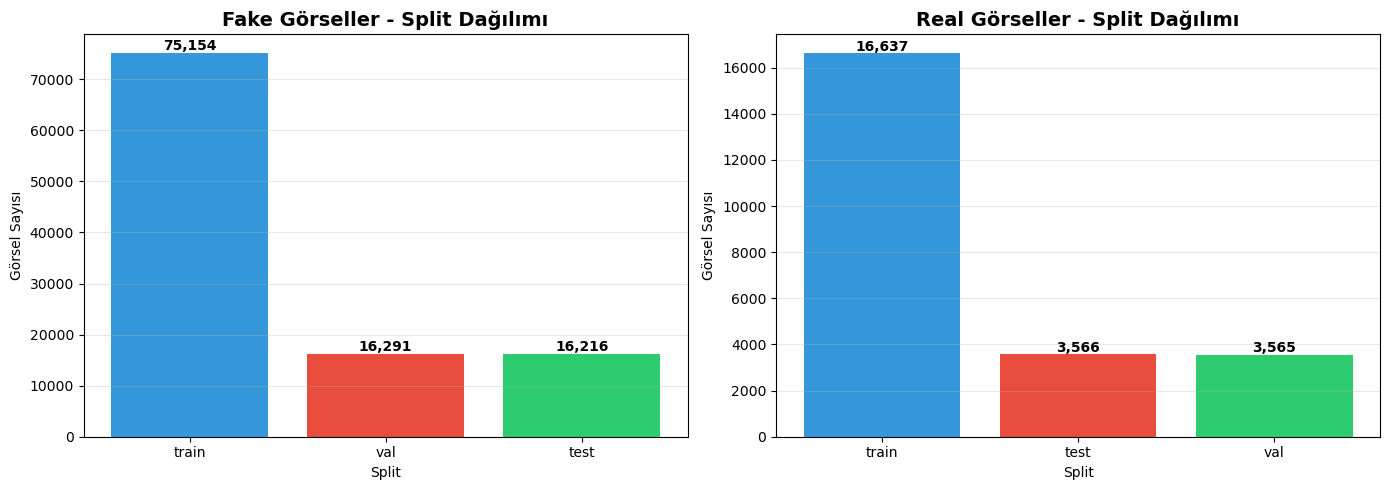

   ✅ split_distribution.png kaydedildi


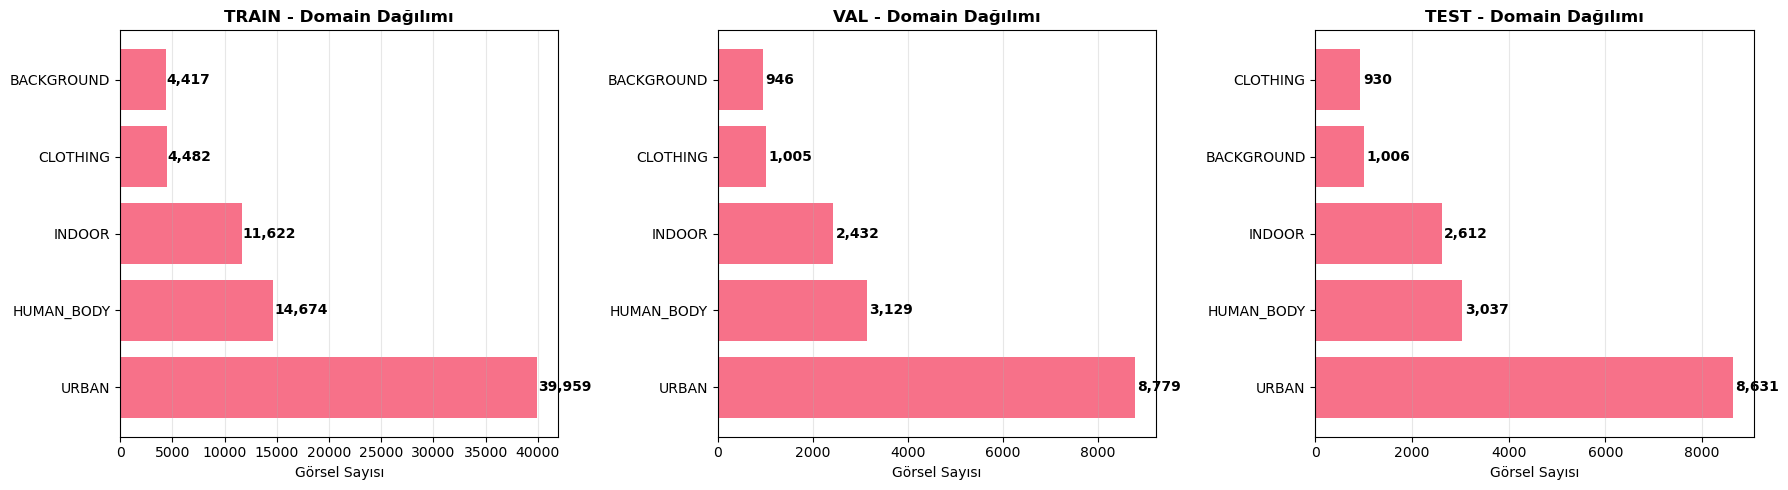

   ✅ domain_distribution_by_split.png kaydedildi


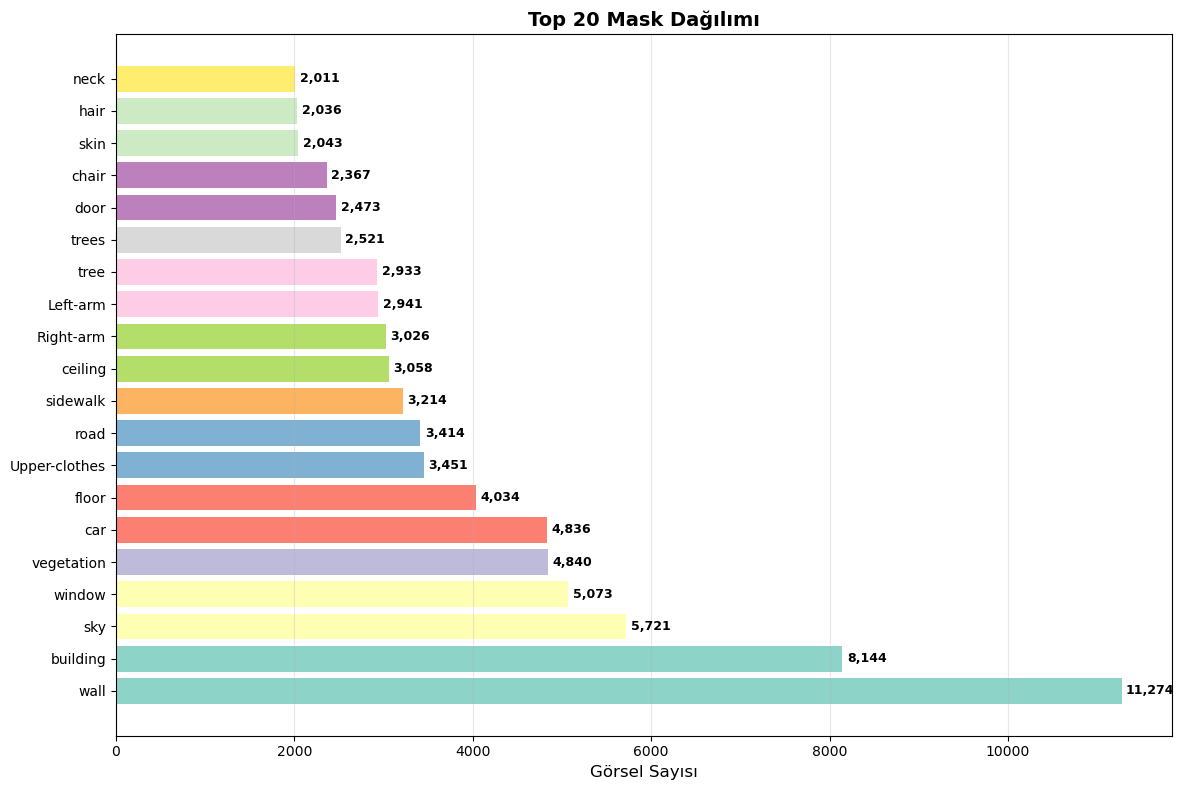

   ✅ top20_mask_distribution.png kaydedildi


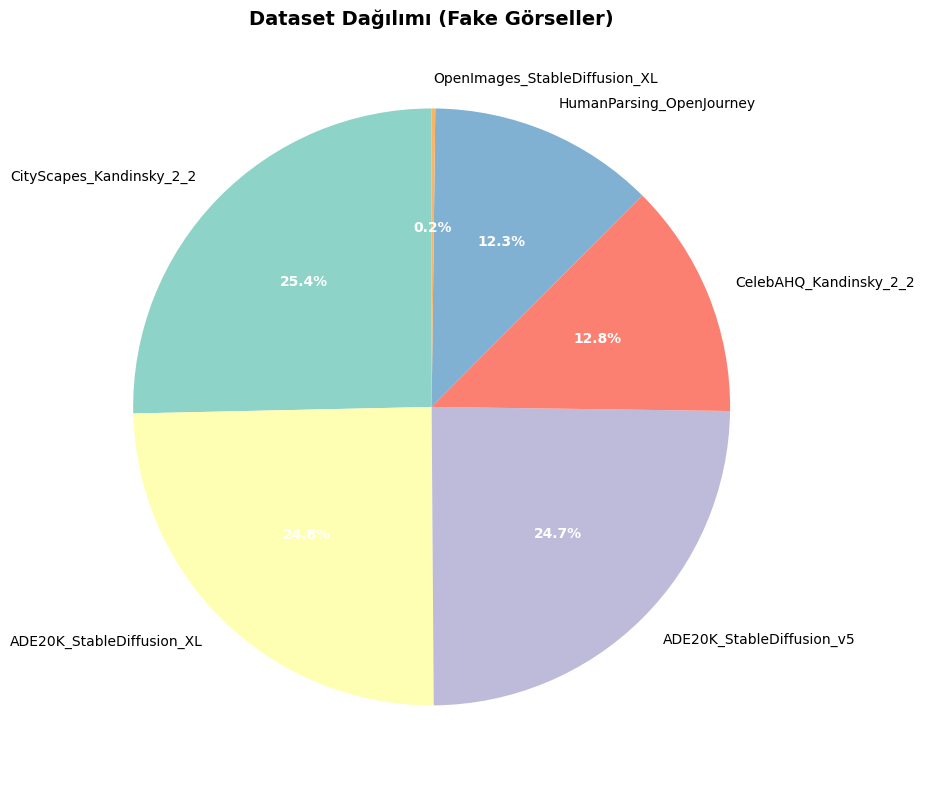

   ✅ dataset_distribution.png kaydedildi

✅ TÜM GÖRSELLEŞTİRMELER OLUŞTURULDU


In [12]:
# =============================================
# 📊 GÖRSELLEŞTİRMELER
# =============================================

print("="*70)
print("📊 GÖRSELLEŞTİRMELER OLUŞTURULUYOR")
print("="*70)

# Stil ayarları
plt.style.use('default')
sns.set_palette("husl")

# 1. Split Dağılımı
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fake split
fake_split_counts = df_fake['split'].value_counts()
axes[0].bar(fake_split_counts.index, fake_split_counts.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Fake Görseller - Split Dağılımı', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Split')
axes[0].set_ylabel('Görsel Sayısı')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(fake_split_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# Real split
real_split_counts = df_real['split'].value_counts()
axes[1].bar(real_split_counts.index, real_split_counts.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Real Görseller - Split Dağılımı', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Split')
axes[1].set_ylabel('Görsel Sayısı')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(real_split_counts.values):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'split_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("   ✅ split_distribution.png kaydedildi")

# 2. Domain Dağılımı (Her split için)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, split in enumerate(['train', 'val', 'test']):
    split_df = df_fake[df_fake['split'] == split]
    domain_counts = split_df['domain'].value_counts()
    
    axes[idx].barh(domain_counts.index, domain_counts.values)
    axes[idx].set_title(f'{split.upper()} - Domain Dağılımı', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Görsel Sayısı')
    axes[idx].grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(domain_counts.values):
        axes[idx].text(v + 50, i, f'{v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'domain_distribution_by_split.png'), dpi=150, bbox_inches='tight')
plt.show()

print("   ✅ domain_distribution_by_split.png kaydedildi")

# 3. Mask Dağılımı (Top 20)
fig, ax = plt.subplots(figsize=(12, 8))

mask_counts = df_fake['mask_name'].value_counts().head(20)
colors = [plt.cm.Set3(i/len(mask_counts)) for i in range(len(mask_counts))]

ax.barh(range(len(mask_counts)), mask_counts.values, color=colors)
ax.set_yticks(range(len(mask_counts)))
ax.set_yticklabels(mask_counts.index)
ax.set_xlabel('Görsel Sayısı', fontsize=12)
ax.set_title('Top 20 Mask Dağılımı', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(mask_counts.values):
    ax.text(v + 50, i, f'{v:,}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'top20_mask_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("   ✅ top20_mask_distribution.png kaydedildi")

# 4. Dataset Dağılımı (Pie chart)
fig, ax = plt.subplots(figsize=(10, 8))

dataset_counts = df_fake['dataset'].value_counts()
colors = plt.cm.Set3(range(len(dataset_counts)))

wedges, texts, autotexts = ax.pie(
    dataset_counts.values, 
    labels=dataset_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax.set_title('Dataset Dağılımı (Fake Görseller)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'dataset_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("   ✅ dataset_distribution.png kaydedildi")

print(f"\n{'='*70}")
print("✅ TÜM GÖRSELLEŞTİRMELER OLUŞTURULDU")
print("="*70)

## 1️⃣3️⃣ Metadata Kaydet

In [13]:
# =============================================
# 💾 SPLIT METADATA KAYDET
# =============================================

print("="*70)
print("💾 SPLIT METADATA KAYDEDILIYOR")
print("="*70)

metadata = {
    "creation_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "split_strategy": "real_id_based",
    "split_ratios": {
        "train": TRAIN_RATIO,
        "val": VAL_RATIO,
        "test": TEST_RATIO
    },
    "domains": {
        "count": NUM_DOMAINS,
        "names": DOMAIN_NAMES,
        "categories": {domain: len(masks) for domain, masks in DOMAIN_CATEGORIES.items()}
    },
    "masks": {
        "total": total_masks,
        "by_domain": {domain: masks for domain, masks in DOMAIN_CATEGORIES.items()}
    },
    "statistics": {
        "fake_images": {
            "total": len(df_fake),
            "unique_real_ids": df_fake['real_img_id'].nunique(),
            "unique_masks": df_fake['mask_name'].nunique(),
            "by_split": {
                "train": len(df_fake[df_fake['split'] == 'train']),
                "val": len(df_fake[df_fake['split'] == 'val']),
                "test": len(df_fake[df_fake['split'] == 'test'])
            },
            "by_domain": df_fake['domain'].value_counts().to_dict()
        },
        "real_images": {
            "total": len(df_real),
            "by_split": {
                "train": len(df_real[df_real['split'] == 'train']),
                "val": len(df_real[df_real['split'] == 'val']),
                "test": len(df_real[df_real['split'] == 'test'])
            }
        }
    },
    "data_leakage_check": {
        "train_val_overlap": len(train_real & val_real),
        "train_test_overlap": len(train_real & test_real),
        "val_test_overlap": len(val_real & test_real),
        "status": "CLEAN" if (len(train_real & val_real) == 0 and 
                             len(train_real & test_real) == 0 and 
                             len(val_real & test_real) == 0) else "LEAKAGE_DETECTED"
    },
    "output_files": {
        "fake_only_split": ["fake_train.csv", "fake_val.csv", "fake_test.csv"],
        "real_only_split": ["real_train.csv", "real_val.csv", "real_test.csv"],
        "paired_split": ["paired_train.csv", "paired_val.csv", "paired_test.csv"]
    },
    "paths": {
        "csv_base": CSV_BASE,
        "extracted_fake": EXTRACTED_BASE_FAKE,
        "extracted_real": EXTRACTED_BASE_REAL,
        "output_dir": OUTPUT_DIR
    }
}

# JSON olarak kaydet
metadata_path = os.path.join(OUTPUT_DIR, "split_metadata.json")
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"✅ Metadata kaydedildi: {metadata_path}")

# Özet yazdır
print(f"\n{'='*70}")
print("✅ DATA PREPARATION TAMAMLANDI!")
print("="*70)
print(f"\n📁 Output Klasörü: {OUTPUT_DIR}")
print(f"\n📊 Oluşturulan Dosyalar:")
print(f"   ├─ fake_only_split/")
print(f"   │  ├─ fake_train.csv  ({len(df_fake[df_fake['split'] == 'train']):,} satır)")
print(f"   │  ├─ fake_val.csv    ({len(df_fake[df_fake['split'] == 'val']):,} satır)")
print(f"   │  └─ fake_test.csv   ({len(df_fake[df_fake['split'] == 'test']):,} satır)")
print(f"   ├─ real_only_split/")
print(f"   │  ├─ real_train.csv  ({len(df_real[df_real['split'] == 'train']):,} satır)")
print(f"   │  ├─ real_val.csv    ({len(df_real[df_real['split'] == 'val']):,} satır)")
print(f"   │  └─ real_test.csv   ({len(df_real[df_real['split'] == 'test']):,} satır)")
print(f"   ├─ paired_split/")
print(f"   │  ├─ paired_train.csv")
print(f"   │  ├─ paired_val.csv")
print(f"   │  └─ paired_test.csv")
print(f"   ├─ split_metadata.json")
print(f"   └─ [Görselleştirmeler]")
print(f"\n🎯 Data Leakage: {metadata['data_leakage_check']['status']}")
print(f"✅ Notebook başarıyla tamamlandı!")
print("="*70)

💾 SPLIT METADATA KAYDEDILIYOR
✅ Metadata kaydedildi: dataset_splits\split_metadata.json

✅ DATA PREPARATION TAMAMLANDI!

📁 Output Klasörü: dataset_splits

📊 Oluşturulan Dosyalar:
   ├─ fake_only_split/
   │  ├─ fake_train.csv  (75,154 satır)
   │  ├─ fake_val.csv    (16,291 satır)
   │  └─ fake_test.csv   (16,216 satır)
   ├─ real_only_split/
   │  ├─ real_train.csv  (16,637 satır)
   │  ├─ real_val.csv    (3,565 satır)
   │  └─ real_test.csv   (3,566 satır)
   ├─ paired_split/
   │  ├─ paired_train.csv
   │  ├─ paired_val.csv
   │  └─ paired_test.csv
   ├─ split_metadata.json
   └─ [Görselleştirmeler]

🎯 Data Leakage: CLEAN
✅ Notebook başarıyla tamamlandı!
